In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pickle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/PFA/wav'

# Hyperparameters
n_mfcc = 13         # Number of MFCC features
max_pad_len = 100   # Pad or truncate MFCCs to this length
batch_size = 64     # Optimized batch size for batch processing

In [ ]:
def extract_mfcc_features(audio, sample_rate, n_mfcc=n_mfcc, max_pad_len=max_pad_len):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    if mfccs is None or len(mfccs) == 0:
        print("Warning: MFCC extraction returned None or empty array.")
        return None
    mfccs = np.pad(mfccs, ((0, 0), (0, max(0, max_pad_len - mfccs.shape[1]))), mode='constant')
    return mfccs[:, :max_pad_len]

In [ ]:
def augment_audio(audio):
    speed_change = np.random.uniform(0.9, 1.1)
    augmented_audio = librosa.effects.time_stretch(audio, rate=speed_change)
    noise = np.random.randn(len(augmented_audio)) * 0.005
    augmented_audio += noise
    return augmented_audio

In [ ]:
features = []
labels = []

def extract_speaker_id(file_name):
    """Extract speaker ID from the filename (first two digits)."""
    return file_name[:2]  # First two characters represent the speaker ID

for file_name in os.listdir(data_path):
    file_path = os.path.join(data_path, file_name)

    if not file_name.endswith(".wav"):  # Ignore non-audio files
        continue

    speaker = extract_speaker_id(file_name)  # Extract speaker ID
    audio, sample_rate = librosa.load(file_path, sr=None)

    if audio is None or len(audio) == 0:
        print(f"Warning: Audio file {file_path} could not be loaded.")
        continue

    mfcc_features = extract_mfcc_features(audio, sample_rate)
    if mfcc_features is not None:
        features.append(mfcc_features)
        labels.append(speaker)

        # Data Augmentation
        augmented_audio = augment_audio(audio)
        augmented_mfcc = extract_mfcc_features(augmented_audio, sample_rate)
        if augmented_mfcc is not None:
            features.append(augmented_mfcc)
            labels.append(speaker)

In [ ]:
# Convert features and labels to numpy arrays
X = np.array(features)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_mfcc, max_pad_len, 1)),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for training
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1, write_graph=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="./best_model_Emodb.keras",
    monitor="val_loss",  # Saves the best model based on validation loss
    save_best_only=True  # Avoids overwriting with worse models
)



# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler, tensorboard_cb,checkpoint_cb],
    verbose=1
)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.1850 - loss: 2.2372 - val_accuracy: 0.1075 - val_loss: 3.2388 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4486 - loss: 1.6985 - val_accuracy: 0.1449 - val_loss: 2.8794 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6551 - loss: 1.1643 - val_accuracy: 0.1075 - val_loss: 2.7228 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7565 - loss: 0.7970 - val_accuracy: 0.2196 - val_loss: 2.0906 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8458 - loss: 0.5621 - val_accuracy: 0.3551 - val_loss: 1.9137 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9129 - loss: 0.3364 - val_accuracy: 0.2710 - val_loss: 2.0159 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9384 - loss: 0.2422 

In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9780 - loss: 0.0717  
Test Accuracy: 97.20%


In [ ]:
def predict_speaker(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    if audio is None or len(audio) == 0:
        print(f"Warning: Audio file {file_path} could not be loaded.")
        return None
    mfcc_features = extract_mfcc_features(audio, sample_rate)
    if mfcc_features is None:
        return None
    mfcc_features = np.reshape(mfcc_features, (1, mfcc_features.shape[0], mfcc_features.shape[1], 1))
    prediction = model.predict(mfcc_features)
    speaker_label = np.argmax(prediction)
    speaker_name = label_encoder.inverse_transform([speaker_label])[0]
    return speaker_name

In [ ]:
if __name__ == "__main__":
    test_audio_path = '/content/drive/MyDrive/PFA/wav/03a01Wa.wav'
    identified_speaker = predict_speaker(test_audio_path)
    print(f"The identified speaker is: {identified_speaker}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The identified speaker is: 03


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 13, 100, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13, 100, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 50, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 50, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 50, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 25, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 25, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 25, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 13, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 13, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 13, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,269,920 (4.84 MB)

 Trainable params: 422,986 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 845,974 (3.23 MB)

Text(0.5, 1.0, 'Loss Curve')

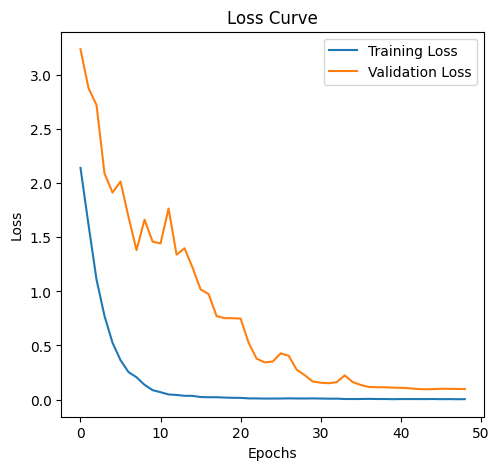

In [ ]:
import matplotlib.pyplot as plt


# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')


Text(0.5, 1.0, 'Accuracy Curve')

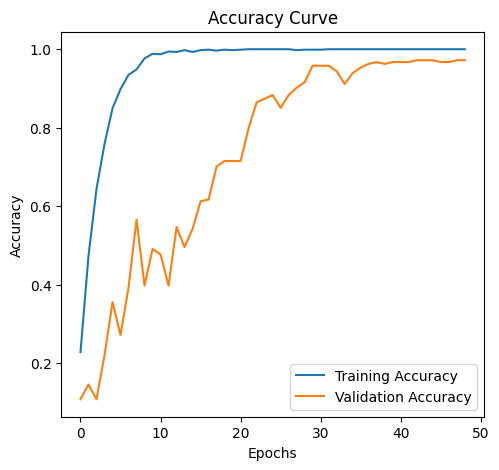

In [ ]:
# Plot Accuracy Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


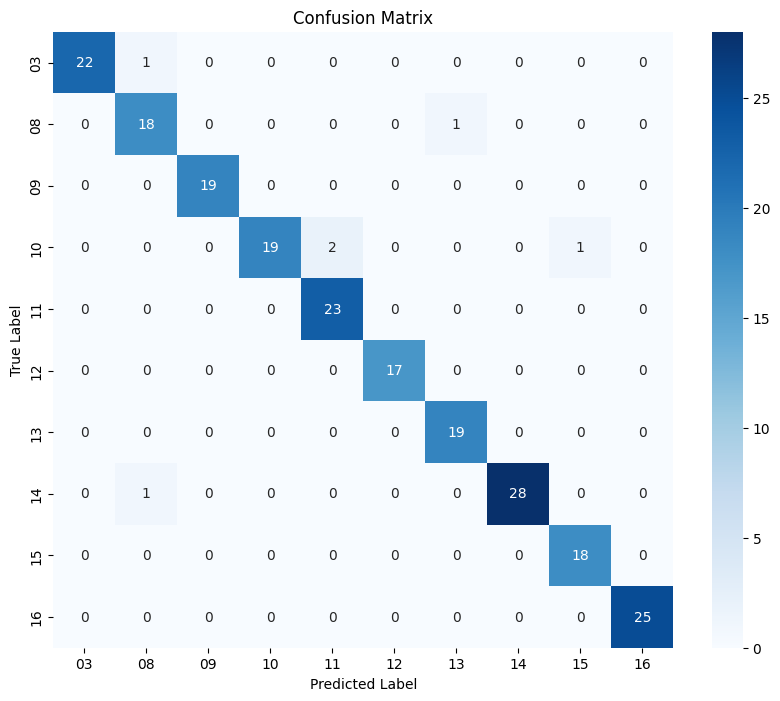

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Get the true labels in their original form
y_true = label_encoder.inverse_transform(y_test.argmax(axis=1))  # FIXED

# Compute confusion matrix
cm = confusion_matrix(y_true, label_encoder.inverse_transform(y_pred_classes))  # FIXED

# Plot it
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.9 MB/s eta 0:00:00


Text(0.5, 0.98, 'First-Layer CNN Filters (Time-Freq Patterns)')

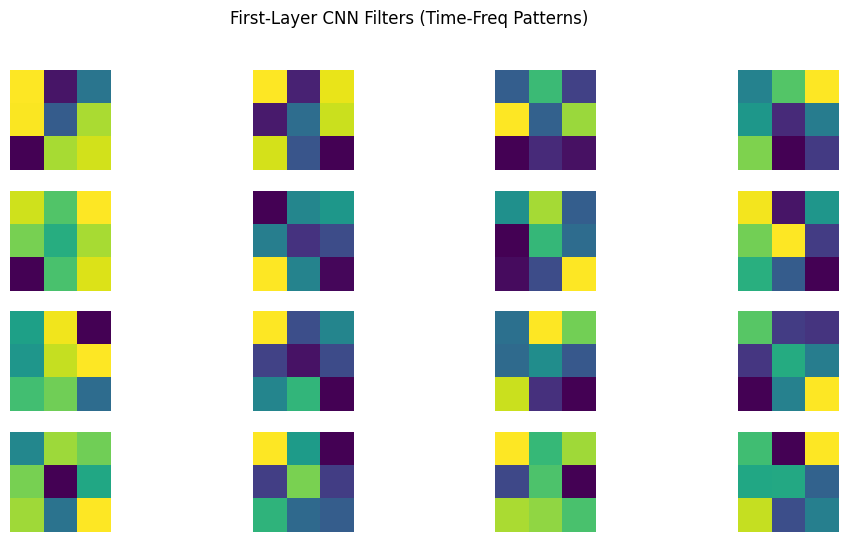

In [ ]:
# Plot the first-layer filters (for spectrogram inputs)
filters, biases = model.layers[0].get_weights()
plt.figure(figsize=(12, 6))
for i in range(min(16, filters.shape[-1])):  # Plot first 16 filters
    plt.subplot(4, 4, i+1)
    plt.imshow(filters[:, :, 0, i], cmap='viridis')  # Assuming input is (time, freq, 1)
    plt.axis('off')
plt.suptitle('First-Layer CNN Filters (Time-Freq Patterns)')

In [ ]:
correct_conf = np.max(model.predict(X_test[y_pred == y_test]), axis=1)
wrong_conf = np.max(model.predict(X_test[y_pred != y_test]), axis=1)
plt.hist([correct_conf, wrong_conf], bins=20, label=['Correct', 'Wrong'])
plt.xlabel('Model Confidence')
plt.legend()

ValueError: operands could not be broadcast together with shapes (214,) (214,10) 